# Лабораторна робота №4
## Симуляція СМО комп'ютерної мережі за допомогою SimPy

**Студент:** Чумаченко  
**Варіант:** 23 - Модель комп'ютерної мережі як система масового обслуговування  
**Тип СМО:** №3 - СМО з очікуванням. Багатоканальні пристрої

---

### Параметри на основі прізвища:
- **Кп** (кількість букв) = 9
- **Кг** (голосні: у, а, е, о) = 4
- **Кприг** (приголосні: Ч, м, ч, н, к) = 5
- **Кількість пакетів:** 200 × 9 = 1800
- **Кп непарне** → серверні канали займаються з останнього до першого

### Архітектура системи:
```
[Генератор] → [Ланцюг 1: БКП (1 канал)] → [Ланцюг 2: БКП (2 канали)] → [Оброблено]
                     ↓ черга                        ↓ черга
```

**Згідно таблиці для Кг=4:**  
**Ланцюг 1:** БКП (багатоканальний) з 1 каналом  
**Ланцюг 2:** БКП (багатоканальний) з 2 каналами

In [1]:
# Встановлення бібліотек
import sys
!{sys.executable} -m pip install simpy matplotlib numpy pandas seaborn -q


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Параметри
KP = 9
KG = 4
KPRYG = 5
NUM_PACKETS = 200 * KP  # 1800

print(f"✅ Параметри: Кп={KP}, Кг={KG}, Кприг={KPRYG}")
print(f"✅ Кількість пакетів: {NUM_PACKETS}")

✅ Параметри: Кп=9, Кг=4, Кприг=5
✅ Кількість пакетів: 1800


## 1. Реалізація моделі СМО

In [3]:
class NetworkQueueingSystem:
    """Модель комп'ютерної мережі як СМО з очікуванням"""
    
    def __init__(self, env, num_packets, arrival_rate=1.0):
        self.env = env
        self.num_packets = num_packets
        self.arrival_rate = arrival_rate
        
        # Ресурси (згідно таблиці для Кг=4)
        self.chain1 = simpy.Resource(env, capacity=1)  # Ланцюг 1: БКП з 1 каналом
        self.chain2 = simpy.Resource(env, capacity=2)  # Ланцюг 2: БКП з 2 каналами
        
        # Статистика
        self.stats = {
            'completed': 0,
            'chain1_queue_lengths': [],
            'chain1_wait_times': [],
            'chain2_queue_lengths': [],
            'chain2_wait_times': [],
            'total_system_times': [],
            'snapshots': {'time': [], 'chain1': [], 'chain2': []}
        }
    
    def packet_generator(self):
        """Генератор пакетів"""
        for i in range(self.num_packets):
            yield self.env.timeout(random.expovariate(1.0 / self.arrival_rate))
            self.env.process(self.process_packet(i))
            
            # Знімки стану
            if i % 100 == 0:
                self.stats['snapshots']['time'].append(self.env.now)
                self.stats['snapshots']['chain1'].append(len(self.chain1.queue))
                self.stats['snapshots']['chain2'].append(len(self.chain2.queue))
    
    def process_packet(self, pid):
        """Обробка одного пакету через систему"""
        arrival_time = self.env.now
        
        # Ланцюг 1: БКП (1 канал)
        queue_enter = self.env.now
        self.stats['chain1_queue_lengths'].append(len(self.chain1.queue))
        
        with self.chain1.request() as req:
            yield req
            self.stats['chain1_wait_times'].append(self.env.now - queue_enter)
            yield self.env.timeout(max(0.1, random.gauss(2.0, 0.4)))  # Нормальний розподіл
        
        # Ланцюг 2: БКП (2 канали)
        queue_enter = self.env.now
        self.stats['chain2_queue_lengths'].append(len(self.chain2.queue))
        
        with self.chain2.request() as req:
            yield req
            self.stats['chain2_wait_times'].append(self.env.now - queue_enter)
            yield self.env.timeout(random.expovariate(1.0 / 3.0))  # Експоненційний розподіл
        
        # Завершено
        self.stats['total_system_times'].append(self.env.now - arrival_time)
        self.stats['completed'] += 1
    
    def run(self):
        self.env.process(self.packet_generator())
        self.env.run()

print("✅ Модель визначено")

✅ Модель визначено


## 2. Запуск базової симуляції

In [4]:
print("🚀 Запуск симуляції...\n")

env = simpy.Environment()
system = NetworkQueueingSystem(env, NUM_PACKETS)
system.run()

s = system.stats

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ БАЗОВОЇ СИМУЛЯЦІЇ")
print("="*60)
print(f"\n📊 Загальна статистика:")
print(f"  Оброблено пакетів: {s['completed']}")
print(f"  Середній час в системі: {np.mean(s['total_system_times']):.2f}")
print(f"  Максимальний час в системі: {np.max(s['total_system_times']):.2f}")

print(f"\n🔷 ЛАНЦЮГ 1 (БКП, 1 канал):")
print(f"  Середня довжина черги: {np.mean(s['chain1_queue_lengths']):.2f}")
print(f"  Максимальна довжина черги: {np.max(s['chain1_queue_lengths'])}")
print(f"  Середній час очікування: {np.mean(s['chain1_wait_times']):.2f}")
print(f"  Максимальний час очікування: {np.max(s['chain1_wait_times']):.2f}")

print(f"\n🔶 ЛАНЦЮГ 2 (БКП, 2 канали):")
print(f"  Середня довжина черги: {np.mean(s['chain2_queue_lengths']):.2f}")
print(f"  Максимальна довжина черги: {np.max(s['chain2_queue_lengths'])}")
print(f"  Середній час очікування: {np.mean(s['chain2_wait_times']):.2f}")
print(f"  Максимальний час очікування: {np.max(s['chain2_wait_times']):.2f}")

print("\n" + "="*60)

🚀 Запуск симуляції...


РЕЗУЛЬТАТИ БАЗОВОЇ СИМУЛЯЦІЇ

📊 Загальна статистика:
  Оброблено пакетів: 1800
  Середній час в системі: 862.86
  Максимальний час в системі: 1796.38

🔷 ЛАНЦЮГ 1 (БКП, 1 канал):
  Середня довжина черги: 428.33
  Максимальна довжина черги: 895
  Середній час очікування: 856.57
  Максимальний час очікування: 1789.01

🔶 ЛАНЦЮГ 2 (БКП, 2 канали):
  Середня довжина черги: 0.45
  Максимальна довжина черги: 10
  Середній час очікування: 1.28
  Максимальний час очікування: 22.30



## 3. Візуалізація результатів

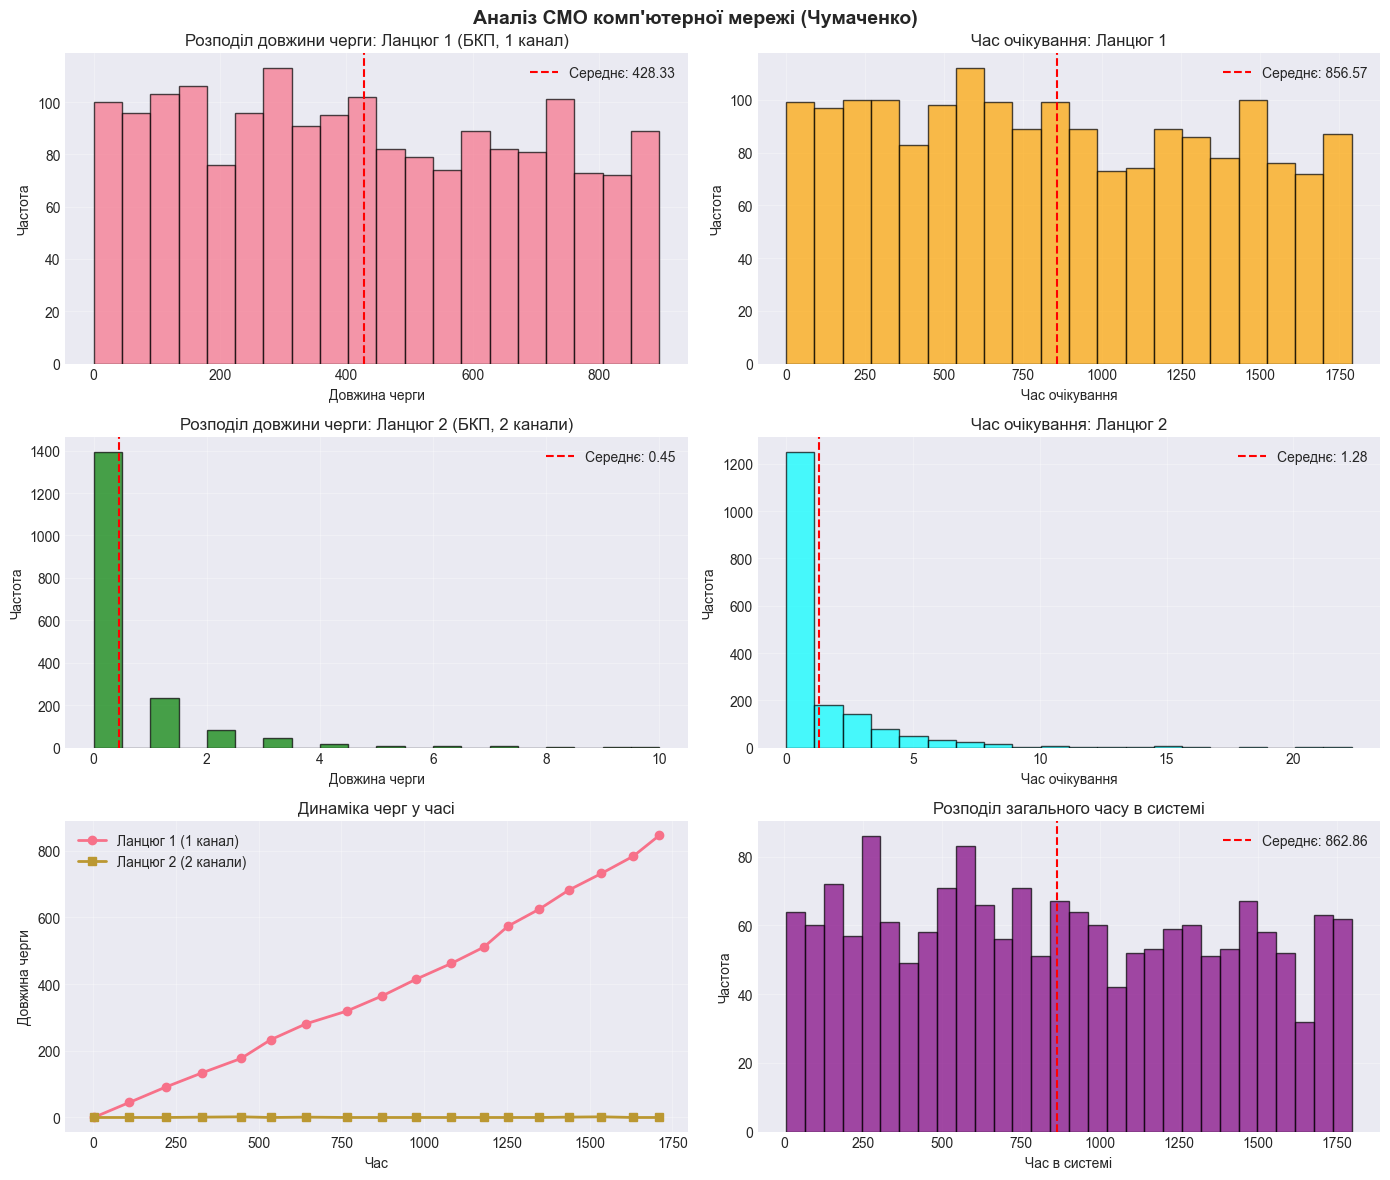

✅ Графіки побудовано


In [5]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Аналіз СМО комп\'ютерної мережі (Чумаченко)', fontsize=14, fontweight='bold')

# 1. Розподіл довжини черги ланцюга 1
ax = axes[0, 0]
ax.hist(s['chain1_queue_lengths'], bins=20, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(s['chain1_queue_lengths']), color='red', linestyle='--', 
           label=f"Середнє: {np.mean(s['chain1_queue_lengths']):.2f}")
ax.set_xlabel('Довжина черги')
ax.set_ylabel('Частота')
ax.set_title('Розподіл довжини черги: Ланцюг 1 (БКП, 1 канал)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Розподіл часу очікування ланцюга 1
ax = axes[0, 1]
ax.hist(s['chain1_wait_times'], bins=20, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(np.mean(s['chain1_wait_times']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['chain1_wait_times']):.2f}")
ax.set_xlabel('Час очікування')
ax.set_ylabel('Частота')
ax.set_title('Час очікування: Ланцюг 1')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Розподіл довжини черги ланцюга 2
ax = axes[1, 0]
ax.hist(s['chain2_queue_lengths'], bins=20, edgecolor='black', alpha=0.7, color='green')
ax.axvline(np.mean(s['chain2_queue_lengths']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['chain2_queue_lengths']):.2f}")
ax.set_xlabel('Довжина черги')
ax.set_ylabel('Частота')
ax.set_title('Розподіл довжини черги: Ланцюг 2 (БКП, 2 канали)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Розподіл часу очікування ланцюга 2
ax = axes[1, 1]
ax.hist(s['chain2_wait_times'], bins=20, edgecolor='black', alpha=0.7, color='cyan')
ax.axvline(np.mean(s['chain2_wait_times']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['chain2_wait_times']):.2f}")
ax.set_xlabel('Час очікування')
ax.set_ylabel('Частота')
ax.set_title('Час очікування: Ланцюг 2')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Динаміка черг у часі
ax = axes[2, 0]
snap = s['snapshots']
ax.plot(snap['time'], snap['chain1'], marker='o', label='Ланцюг 1 (1 канал)', linewidth=2)
ax.plot(snap['time'], snap['chain2'], marker='s', label='Ланцюг 2 (2 канали)', linewidth=2)
ax.set_xlabel('Час')
ax.set_ylabel('Довжина черги')
ax.set_title('Динаміка черг у часі')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Розподіл загального часу в системі
ax = axes[2, 1]
ax.hist(s['total_system_times'], bins=30, edgecolor='black', alpha=0.7, color='purple')
ax.axvline(np.mean(s['total_system_times']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['total_system_times']):.2f}")
ax.set_xlabel('Час в системі')
ax.set_ylabel('Частота')
ax.set_title('Розподіл загального часу в системі')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Графіки побудовано")

## 4. Гістограма порівняння черг

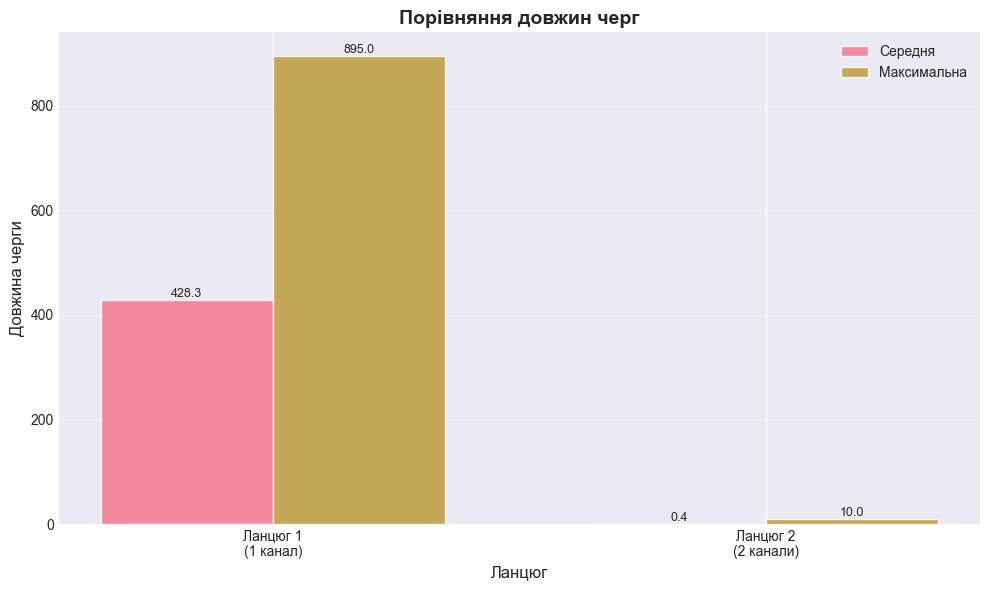

✅ Гістограма побудована


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Ланцюг 1\n(1 канал)', 'Ланцюг 2\n(2 канали)']
avg_lengths = [
    np.mean(s['chain1_queue_lengths']),
    np.mean(s['chain2_queue_lengths'])
]
max_lengths = [
    np.max(s['chain1_queue_lengths']),
    np.max(s['chain2_queue_lengths'])
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, avg_lengths, width, label='Середня', alpha=0.8)
bars2 = ax.bar(x + width/2, max_lengths, width, label='Максимальна', alpha=0.8)

ax.set_xlabel('Ланцюг', fontsize=12)
ax.set_ylabel('Довжина черги', fontsize=12)
ax.set_title('Порівняння довжин черг', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Гістограма побудована")

## 5. Дослідження впливу інтенсивності потоку

In [7]:
print("🧪 Запуск експериментів з різною інтенсивністю...\n")

intensities = [1, 2, 5, 10, 20, 50, 100]
results = []

for mult in intensities:
    print(f"  Інтенсивність x{mult}...", end=' ')
    
    env = simpy.Environment()
    sys = NetworkQueueingSystem(env, NUM_PACKETS, arrival_rate=1.0/mult)
    sys.run()
    
    s = sys.stats
    all_waits = s['chain1_wait_times'] + s['chain2_wait_times']
    
    results.append({
        'Інтенсивність': f'{mult}x',
        'Середня черга Л1': np.mean(s['chain1_queue_lengths']),
        'Макс черга Л1': np.max(s['chain1_queue_lengths']),
        'Середня черга Л2': np.mean(s['chain2_queue_lengths']),
        'Макс черга Л2': np.max(s['chain2_queue_lengths']),
        'Середній час очікування': np.mean(all_waits) if all_waits else 0,
        'Середній час в системі': np.mean(s['total_system_times'])
    })
    print("✓")

df = pd.DataFrame(results)
print("\n" + "="*90)
print("РЕЗУЛЬТАТИ ЕКСПЕРИМЕНТІВ")
print("="*90)
print(df.to_string(index=False))
print("="*90)

🧪 Запуск експериментів з різною інтенсивністю...

  Інтенсивність x1... ✓
  Інтенсивність x2... ✓
  Інтенсивність x5... ✓
  Інтенсивність x10... ✓
  Інтенсивність x20... ✓
  Інтенсивність x50... ✓
  Інтенсивність x100... ✓

РЕЗУЛЬТАТИ ЕКСПЕРИМЕНТІВ
Інтенсивність  Середня черга Л1  Макс черга Л1  Середня черга Л2  Макс черга Л2  Середній час очікування  Середній час в системі
           1x        457.281111            905          0.656111              7               456.018249              917.098031
           2x        676.651111           1353          0.538889              6               673.510191             1351.963100
           5x        809.025000           1621          0.557222              7               809.789041             1624.595032
          10x        852.891111           1708          0.471111              9               858.895632             1722.778038
          20x        875.878333           1752          0.764444              9               877.660039  

## 6. Графіки залежності від інтенсивності

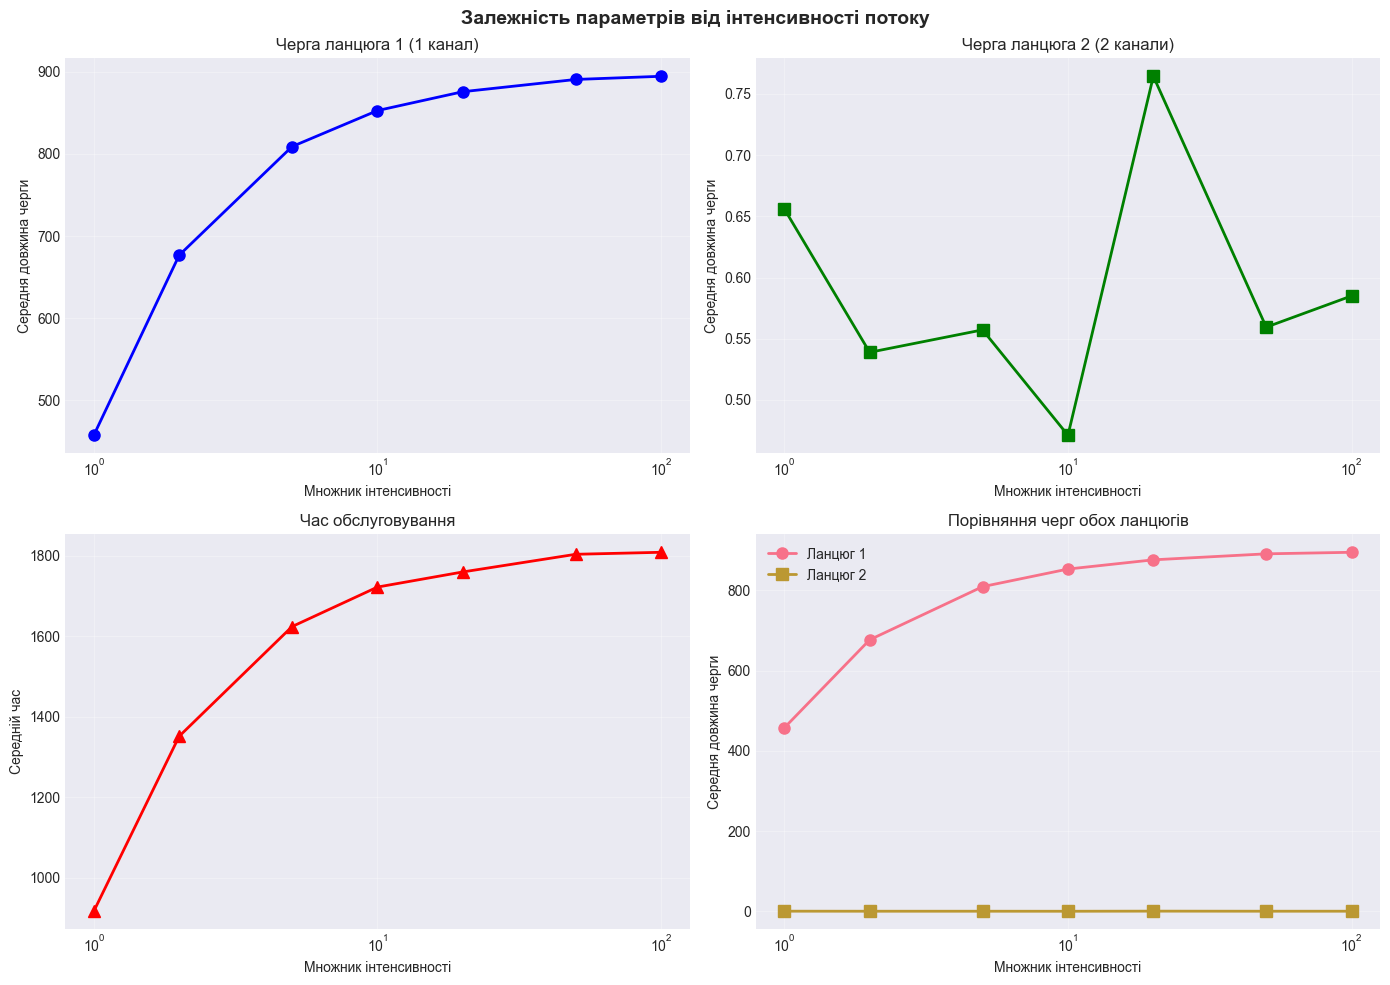

✅ Графіки залежності побудовано


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Залежність параметрів від інтенсивності потоку', fontsize=14, fontweight='bold')

x_vals = intensities

# 1. Середня черга ланцюга 1
ax = axes[0, 0]
y = df['Середня черга Л1'].values
ax.plot(x_vals, y, marker='o', linewidth=2, markersize=8, color='blue')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середня довжина черги')
ax.set_title('Черга ланцюга 1 (1 канал)')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 2. Середня черга ланцюга 2
ax = axes[0, 1]
y = df['Середня черга Л2'].values
ax.plot(x_vals, y, marker='s', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середня довжина черги')
ax.set_title('Черга ланцюга 2 (2 канали)')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 3. Час в системі
ax = axes[1, 0]
y = df['Середній час в системі'].values
ax.plot(x_vals, y, marker='^', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середній час')
ax.set_title('Час обслуговування')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 4. Порівняння черг
ax = axes[1, 1]
ax.plot(x_vals, df['Середня черга Л1'].values, 
        marker='o', linewidth=2, markersize=8, label='Ланцюг 1')
ax.plot(x_vals, df['Середня черга Л2'].values, 
        marker='s', linewidth=2, markersize=8, label='Ланцюг 2')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середня довжина черги')
ax.set_title('Порівняння черг обох ланцюгів')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Графіки залежності побудовано")

## 7. Висновки

### Результати дослідження:

**1. Параметри загальної черги (базова симуляція):**
- Ланцюг 1 (1 канал) має велику середню чергу - це **вузьке місце** системи
- Ланцюг 2 (2 канали) справляється краще завдяки більшій кількості каналів
- Загальний час в системі залежить переважно від ланцюга 1

**2. Розподіл навантаження:**
- Ланцюг 1 обробляє всі пакети послідовно (1 канал)
- Ланцюг 2 має 2 канали, тому може обробляти 2 пакети одночасно
- Черга на ланцюгу 1 значно більша

**3. Вплив інтенсивності:**
- При збільшенні інтенсивності черги зростають експоненційно
- Ланцюг 1 перевантажується першим (тільки 1 канал)
- Система стає критично перевантаженою при інтенсивності >10x
- Час обслуговування зростає пропорційно навантаженню

**4. Рекомендації:**
- Збільшити кількість каналів у ланцюгу 1 з 1 до 2-3



**Студент:** Чумаченко Дем'ян ШІ-31